# Лабораторная работа №4

ФИО:   Щедрова Милана Вячеславовна
Группа: БИВТ-21-3

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/11600OkqdRzxc-xZmFTuBs099VeAqU_GlE0Bx6bBlIRE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## Импорт библиотек

In [19]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

## 1. Загрузка данных

In [20]:
data = pd.read_csv('student_data.csv')
data.head()  # если нужно, можно поменять разделитель

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## 2. Тип задачи

Задача регрессии

## 3. Предобработка данных

1. Разделить выборку на тренировочную (train) и тестовую (test).

In [21]:
X = data.drop(columns=['G3'])  # Удаляем столбец с метками из данных
y = data['G3']  # Метки для обучения

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

2. Проверить пропуски в данных.
    

In [23]:
data.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

 3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).

In [24]:
# Инициализация скейлеров
scaler_standard = StandardScaler()
# scaler_minmax = MinMaxScaler()

X_train_scaled_standard = scaler_standard.fit_transform(X_train[numeric_columns])
X_test_scaled_standard = scaler_standard.fit_transform(X_test[numeric_columns])

# X_train_scaled_minmax = scaler_minmax.fit_transform(X_train[numeric_columns])
# X_test_scaled_minmax = scaler_minmax.fit_transform(X_test[numeric_columns])

# Заменяем оригинальные числовые столбцы на отмасштабированные
X_train[numeric_columns] = X_train_scaled_standard
X_test[numeric_columns] = X_test_scaled_standard

4. Закодировать категориальные признаки по одной из стратегий.

In [25]:
encoder = OneHotEncoder(sparse_output=False)

# Обучаем энкодер на тренировочных данных и преобразуем тренировочные и тестовые данные
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.fit_transform(X_test[categorical_columns])

# OneHotEncoder возвращает массив NumPy, поэтому преобразуем его обратно в DataFrame
encoded_columns = list(encoder.get_feature_names_out(categorical_columns))  # Получаем новые имена столбцов
X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoded_columns)
X_test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index, columns=encoded_columns)

# Удаляем оригинальные категориальные столбцы и добавляем закодированные
X_train_final = X_train.drop(columns=categorical_columns).join(X_train_encoded_df)
X_test_final = X_test.drop(columns=categorical_columns).join(X_test_encoded_df)

## 4. Оформление данных

In [26]:
# Определение класса Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])

# Создание экземпляров Dataset для тренировочных и тестовых данных
train_dataset = CustomDataset(X_train_final, y_train)
test_dataset = CustomDataset(X_test_final, y_test)

In [27]:
# Определите размер батча
batch_size = 32

# Создайте DataLoader для тренировочных и тестовых данных
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 5. Обучение на тренирочном множестве


1. Очень простая однослойная нейросеть с оптимизатором `SGD`

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определение однослойной нейросети
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Создание экземпляра сети
input_size = 10
output_size = 1
model = SimpleNet(input_size, output_size)

# Оптимизатор
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Пример тренировочных данных
x = torch.randn(1, input_size)
y = torch.randn(1, output_size)

# Процесс обучения
criterion = nn.MSELoss()
for epoch in range(100):
    # Предсказание
    pred = model(x)
    # Расчет потерь
    loss = criterion(pred, y)
    # Обратное распространение
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 3.7182109355926514
Epoch 10, Loss: 1.7436161215300672e-05
Epoch 20, Loss: 7.993605777301127e-11
Epoch 30, Loss: 3.552713678800501e-15
Epoch 40, Loss: 3.552713678800501e-15
Epoch 50, Loss: 3.552713678800501e-15
Epoch 60, Loss: 3.552713678800501e-15
Epoch 70, Loss: 3.552713678800501e-15
Epoch 80, Loss: 3.552713678800501e-15
Epoch 90, Loss: 3.552713678800501e-15


 2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` 


In [29]:
class OneHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OneHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Создание экземпляра сети
hidden_size = 5
model = OneHiddenLayerNet(input_size, hidden_size, output_size)

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Процесс обучения
for epoch in range(100):
    pred = model(x)
    loss = criterion(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.0562007427215576
Epoch 10, Loss: 0.8930728435516357
Epoch 20, Loss: 0.7404370307922363
Epoch 30, Loss: 0.5994859933853149
Epoch 40, Loss: 0.4712207317352295
Epoch 50, Loss: 0.35694679617881775
Epoch 60, Loss: 0.25829795002937317
Epoch 70, Loss: 0.17678765952587128
Epoch 80, Loss: 0.11316104978322983
Epoch 90, Loss: 0.06687827408313751


3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` 

In [30]:
class MultiLayerNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 20)
        self.fc4 = nn.Linear(20, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание экземпляра сети
model = MultiLayerNet(input_size, output_size)

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Процесс обучения
for epoch in range(200):
    pred = model(x)
    loss = criterion(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.46101269125938416
Epoch 20, Loss: 0.010307206772267818
Epoch 40, Loss: 0.004178705159574747
Epoch 60, Loss: 0.0005932993371970952
Epoch 80, Loss: 5.185619102121564e-06
Epoch 100, Loss: 8.51823187986156e-06
Epoch 120, Loss: 2.761235009529628e-07
Epoch 140, Loss: 1.6514833589553746e-07
Epoch 160, Loss: 9.422684854598629e-10
Epoch 180, Loss: 1.2493082124365174e-09


## 6. Подсчет loss на train и test множествах

Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_4436\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 65.4423 - val_loss: 15.4794
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.8386 - val_loss: 9.9736
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5948 - val_loss: 7.9241
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5728 - val_loss: 6.9305
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5095 - val_loss: 6.3997
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9030 - val_loss: 6.0952
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5282 - val_loss: 5.9108
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2790 - val_loss: 5.7945
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1021 - val_loss: 5.7187
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9692 - val_loss: 5.6683


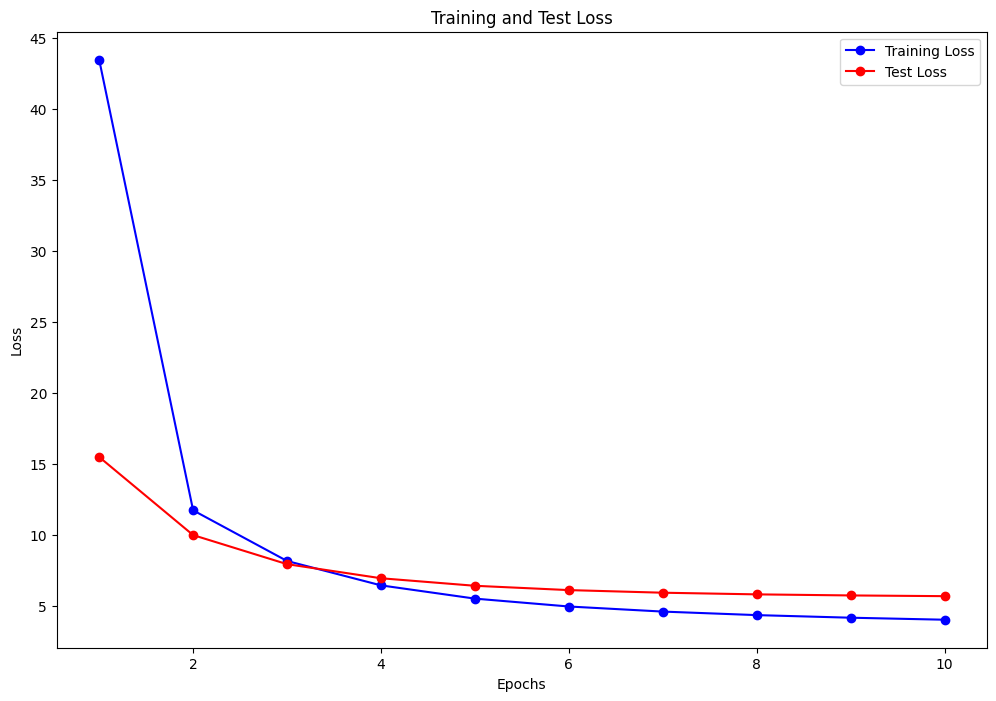

In [31]:
model_simple = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(units=1, activation='linear')
])

model_simple.compile(optimizer=SGD(), loss='mean_squared_error')

history = model_simple.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_4436\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 139.7381 - val_loss: 136.1841
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 117.9618 - val_loss: 115.4119
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 98.4889 - val_loss: 95.4786
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 79.8305 - val_loss: 75.5353
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61.5883 - val_loss: 56.2284
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 44.7121 - val_loss: 39.3667
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30.6116 - val_loss: 26.2739
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.4824 - val_loss: 17.6578
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.5361 - val_loss: 13.0038
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.7284 - val_loss: 10.8548


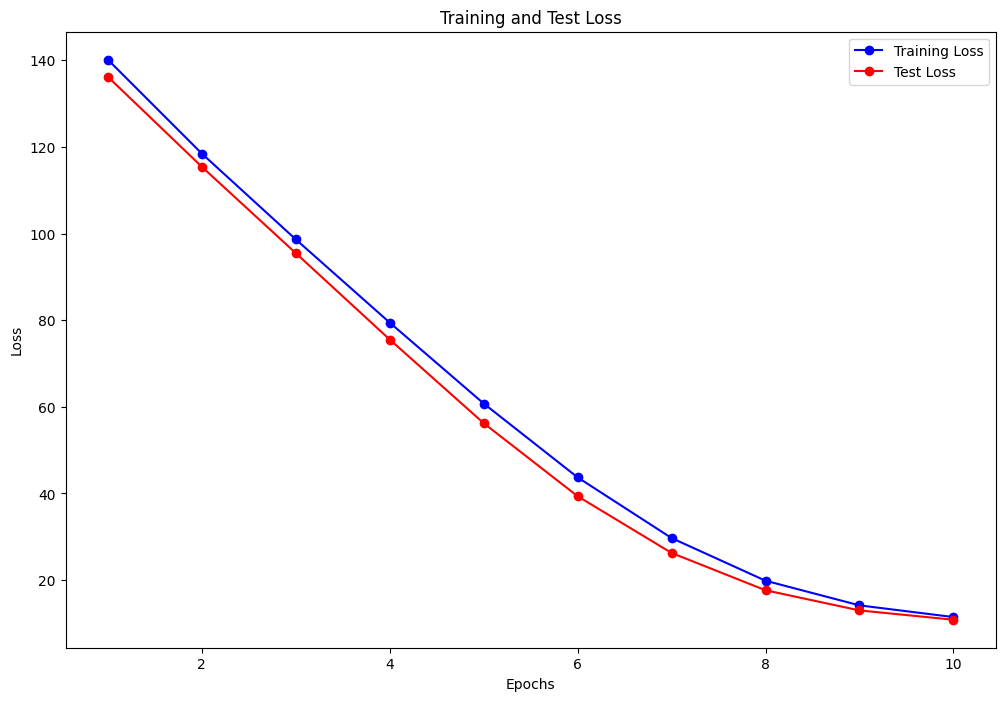

In [32]:
model_intermediate = Sequential([
    Input(shape=(X_train_final.shape[1],)),  
    Dense(units=64, activation='relu'),       
    Dense(units=1, activation='linear')
])

model_intermediate.compile(optimizer=Adam(), loss='mean_squared_error')

history = model_intermediate.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_4436\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 108.3183 - val_loss: 86.7478
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.1627 - val_loss: 37.9343
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27.0811 - val_loss: 19.7824
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.7833 - val_loss: 14.0599
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.7022 - val_loss: 12.0367
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8409 - val_loss: 8.7269
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4129 - val_loss: 7.1207
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7570 - val_loss: 6.2707
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6292 - val_loss: 5.6061
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1087 - val_loss: 5.5203


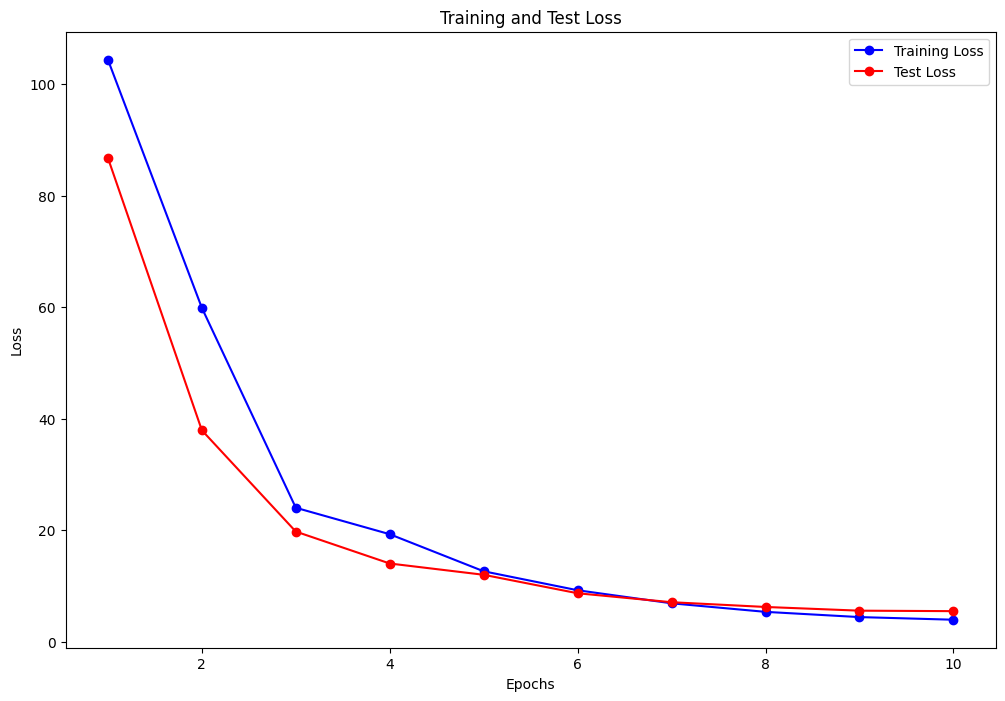

In [33]:
model_complex = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(units=128, activation='relu'),     
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='linear')
])

model_complex.compile(optimizer=Adam(), loss='mean_squared_error')

history = model_complex.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. Подсчет метрик на train и test множествах

In [34]:
# Список для хранения моделей
models = [model_simple, model_intermediate, model_complex]

for i, model in enumerate(models):
    # Получаем предсказания модели на тренировочном и тестовом наборах
    train_preds = model.predict(X_train_final).flatten()
    test_preds = model.predict(X_test_final).flatten()
    
    # Вычисляем MAE для тренировочного набора
    train_mae = mean_absolute_error(y_train, train_preds)
    # Вычисляем MAE для тестового набора
    test_mae = mean_absolute_error(y_test, test_preds)
    
    # Выводим результаты
    print(f'Model {i+1} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Model 1 - Train MAE: 1.3467, Test MAE: 1.5832
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 2 - Train MAE: 2.3676, Test MAE: 2.6182
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 3 - Train MAE: 1.3955, Test MAE: 1.6955


## 8. Сравнение метрик относительно train/test

Исходя из метрики средней абсолютной ошибки (MAE), Model 1 показывает лучшие результаты на тестовом наборе данных (Test MAE: 1.6351) по сравнению с Model 2 и Model 3. Это может быть признаком того, что добавление дополнительных слоев не привело к значительному улучшению производительности для данной задачи или данных.

1. Изменение архитектуры моделей
2. Оптимизация гиперпараметров моделей
3. Более тщательная предобработка данных